In [6]:
# ✅ Install required libraries (run only once)
%pip install rasterio matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [15]:
!pip install pandas
!pip install tqdm

In [8]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime

# === CONFIGURATION ===
BASE_FOLDER = r"D:\s2_asiaEast\asiaEast\ROIs2017\117\S2"  # main folder containing time steps (1, 2, 3, ...)
OUTPUT_FOLDER = r"D:\Timegate Images"  # where to save the final composite

TEMPORAL_DECAY = 0.15  # how quickly older images lose weight
RGB_BANDS = [3, 2, 1]  # Sentinel-2 band indices for RGB (B4, B3, B2)


In [9]:
def load_first_patch_per_time(folder_path):
    """Loads patch_1.tif from each numbered subfolder"""
    print(f"\nScanning time-step folders in:\n  {folder_path}\n")

    time_folders = sorted(
        [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))],
        key=lambda x: int(os.path.basename(x))
    )

    all_data, timestamps, profiles = [], [], []

    for tf in time_folders:
        patch_files = [os.path.join(tf, f) for f in os.listdir(tf) if "patch_16" in f and f.endswith(".tif")]
        if not patch_files:
            print(f"⚠️ No patch_1 found in {tf}, skipping...")
            continue

        fpath = patch_files[0]
        fname = os.path.basename(fpath)
        print(f"Loading {fname} ...")

        # Extract date (e.g., 2018-01-31)
        try:
            date_str = fname.split("_")[5]
            date = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception:
            date = None

        with rasterio.open(fpath) as src:
            data = src.read().astype(np.float32)
            profiles.append(src.profile)

        all_data.append(data)
        timestamps.append(date)

    if not all_data:
        raise RuntimeError("❌ No valid patch_1 images found in subfolders!")

    stack = np.stack(all_data, axis=0)
    print(f"\n✅ Loaded {len(all_data)} images with shape: {stack.shape}")
    return stack, profiles[0], timestamps


In [10]:
def compute_fmask_s2(image):
    """
    Simplified Fmask-like detection for Sentinel-2.
    Returns mask in [0,1]: 1=clear, 0=cloud/shadow/snow/missing.
    """
    B2, B3, B4, B8, B11, B12 = image[1], image[2], image[3], image[7], image[10], image[11]
    B2n, B3n, B4n, B8n, B11n, B12n = [np.clip(b / 10000.0, 0, 1) for b in [B2,B3,B4,B8,B11,B12]]

    ndsi = (B3n - B11n) / (B3n + B11n + 1e-6)  # snow
    ndvi = (B8n - B4n) / (B8n + B4n + 1e-6)    # vegetation
    ndwi = (B3n - B11n) / (B3n + B11n + 1e-6)  # water

    cloud_test = (B2n > 0.25) & (B4n > 0.25) & (B11n < 0.12)
    snow_test  = (ndsi > 0.4) & (B2n > 0.2)
    shadow_test = (B8n < 0.15) & (B4n < 0.1)
    missing = np.all(image == 0, axis=0)

    invalid = cloud_test | snow_test | shadow_test | missing
    clear_mask = (~invalid).astype(np.float32)
    return clear_mask


def timegate_with_fmask(stack, temporal_decay=0.1):
    """TimeGate aggregation considering Fmask-based validity"""
    t, c, h, w = stack.shape
    quality_masks = np.zeros((t, h, w), dtype=np.float32)

    print("\nComputing Fmask for each timestamp...")
    for i in range(t):
        quality_masks[i] = compute_fmask_s2(stack[i])

    decay = np.exp(-temporal_decay * np.arange(t-1, -1, -1).reshape(-1, 1, 1))
    decay /= np.sum(decay)

    H_time = quality_masks * decay
    H_sum = np.sum(H_time, axis=0, keepdims=True) + 1e-10
    H_w = H_time / H_sum

    H_w_expanded = np.repeat(H_w[:, np.newaxis, :, :], c, axis=1)
    composite = np.sum(H_w_expanded * stack, axis=0)

    avg_weights = np.mean(H_w, axis=(1, 2))
    return composite, avg_weights, quality_masks


In [11]:
def visualize_rgb(image, title="RGB Composite (Color-Balanced)", stretch=True):
    rgb = np.stack([image[i] for i in RGB_BANDS], axis=-1)

    # Normalize each band individually for balanced colors
    if stretch:
        rgb_balanced = np.zeros_like(rgb, dtype=np.float32)
        for i in range(3):
            band = rgb[:, :, i]
            valid = band[band > 0]
            if valid.size > 100:
                p2, p98 = np.percentile(valid, [2, 98])
                rgb_balanced[:, :, i] = np.clip((band - p2) / (p98 - p2 + 1e-8), 0, 1)
            else:
                rgb_balanced[:, :, i] = band / 10000
        rgb = rgb_balanced
    else:
        rgb /= 10000

    plt.figure(figsize=(7, 7))
    plt.imshow(rgb)
    plt.title(title, fontsize=13, fontweight='bold', color='darkgreen')
    plt.axis("off")
    plt.show()


THis is only for one patch `


Scanning time-step folders in:
  D:\s2_asiaEast\asiaEast\ROIs2017\117\S2

Loading s2_ROIs2017_117_ImgNo_0_2018-01-06_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_1_2018-01-18_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_2_2018-01-31_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_3_2018-02-12_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_4_2018-02-25_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_5_2018-03-07_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_6_2018-03-19_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_7_2018-04-01_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_8_2018-04-13_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_9_2018-04-26_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_10_2018-05-06_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_11_2018-05-18_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_12_2018-05-31_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_13_2018-06-12_patch_16.tif ...
Loading s2_ROIs2017_117_ImgNo_14_2018-06-25_patch_16.tif ...
Loading s2_ROIs2017_

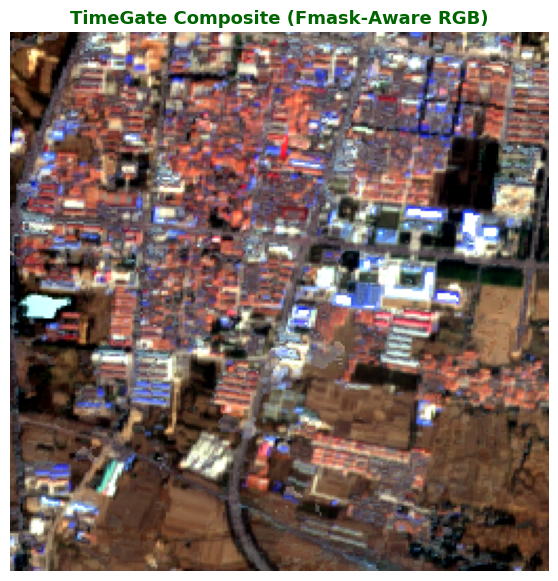

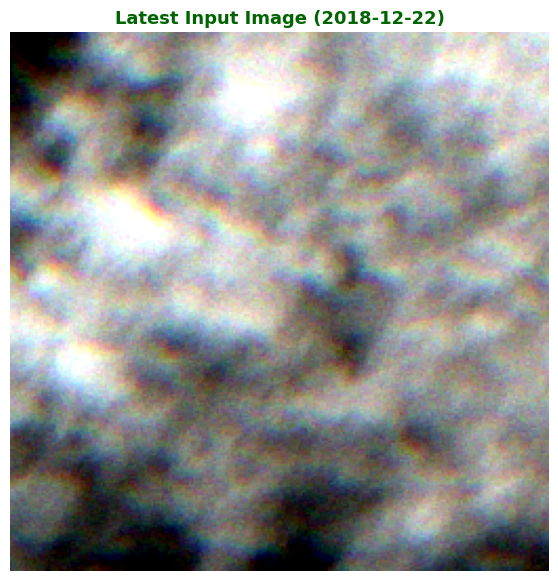


🌟 Highest-weighted image: 2018-10-23 (Weight: 16.27%)


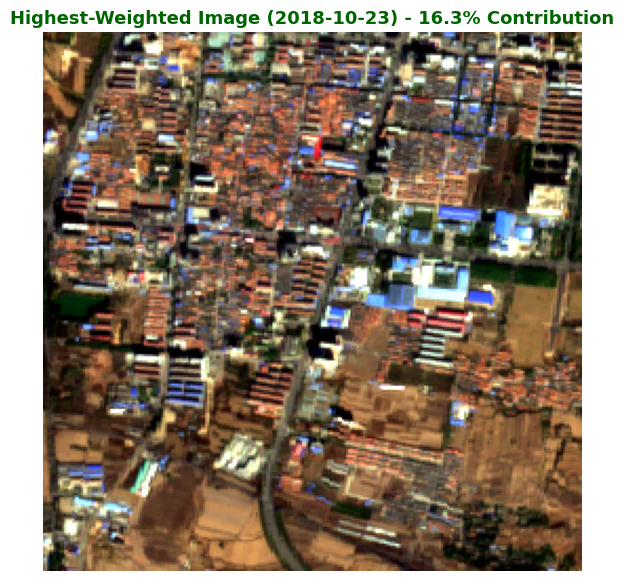

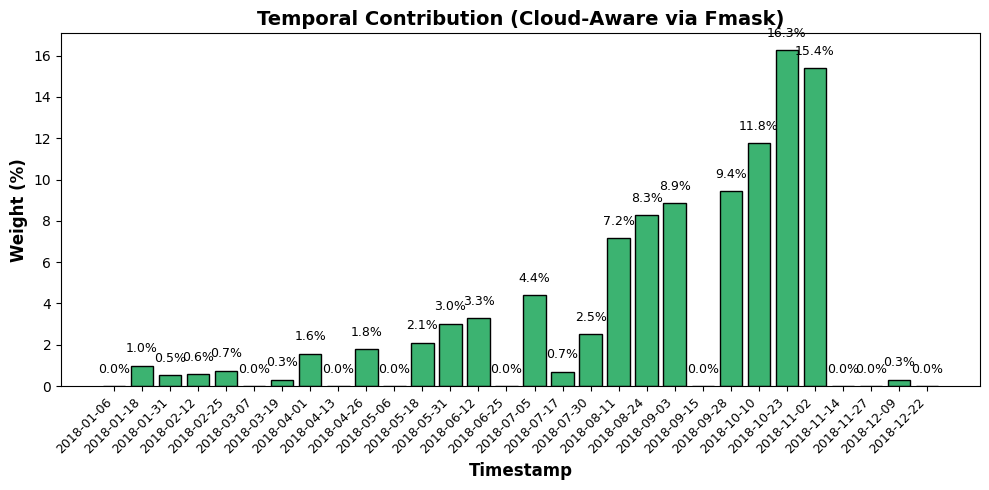

NameError: name 'pd' is not defined

In [12]:
# === MAIN EXECUTION ===

# Step 1: Load patch_1 from each folder
stack, profile, timestamps = load_first_patch_per_time(BASE_FOLDER)

# Step 2: Sort by time
if all(timestamps):
    sort_idx = np.argsort(timestamps)
    stack = stack[sort_idx]
    timestamps = [timestamps[i] for i in sort_idx]
    print("\n🕒 Time order of images:")
    for t in timestamps:
        print("   ", t.strftime("%Y-%m-%d"))

# Step 3: Run TimeGate with Fmask
composite_fmask, avg_weights_fmask, quality_masks = timegate_with_fmask(stack, temporal_decay=TEMPORAL_DECAY)

# Step 4: Visualize Fmask-aware composite
visualize_rgb(composite_fmask, title="TimeGate Composite (Fmask-Aware RGB)")

# Step 5: Visualize the latest image
visualize_rgb(stack[-1], title=f"Latest Input Image ({timestamps[-1].strftime('%Y-%m-%d')})")

# Step 6: Identify and visualize the highest-weighted image
highest_idx = np.argmax(avg_weights_fmask)
highest_date = timestamps[highest_idx]
print(f"\n🌟 Highest-weighted image: {highest_date.strftime('%Y-%m-%d')} (Weight: {avg_weights_fmask[highest_idx]*100:.2f}%)")

visualize_rgb(
    stack[highest_idx],
    title=f"Highest-Weighted Image ({highest_date.strftime('%Y-%m-%d')}) - {avg_weights_fmask[highest_idx]*100:.1f}% Contribution"
)

# Step 7: Plot temporal weights
date_strs = [t.strftime("%Y-%m-%d") for t in timestamps]
weights_norm = (avg_weights_fmask / np.sum(avg_weights_fmask)) * 100

plt.figure(figsize=(10, 5))
bars = plt.bar(date_strs, weights_norm, color='mediumseagreen', edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel("Weight (%)", fontsize=12, fontweight='bold')
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.title("Temporal Contribution (Cloud-Aware via Fmask)", fontsize=14, fontweight='bold')
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.5,
        f"{weights_norm[i]:.1f}%",
        ha='center', va='bottom', fontsize=9
    )
plt.tight_layout()
plt.show()

# Step 8: Save results
latest_ts = max([t for t in timestamps if t])
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Save weights CSV
csv_path = os.path.join(OUTPUT_FOLDER, f"{latest_ts.strftime('%Y-%m-%d')}_Fmask_weights.csv")
pd.DataFrame({"Timestamp": date_strs, "Weight (%)": weights_norm.round(2)}).to_csv(csv_path, index=False)
print(f"📄 Weights CSV saved to: {csv_path}")

# Save composite
filename_out = f"{latest_ts.strftime('%Y-%m-%d')}_timegate_Fmask_composite.tif"
output_path = os.path.join(OUTPUT_FOLDER, filename_out)

profile_out = profile.copy()
profile_out.update({
    "count": composite_fmask.shape[0],
    "dtype": "int16"
})

with rasterio.open(output_path, "w", **profile_out) as dst:
    dst.write(composite_fmask.astype(np.int16))

print("\n" + "="*70)
print(f"✅ SUCCESS: Cloud-aware composite saved to\n   {output_path}")
print("="*70)


In [16]:
# === MAIN EXECUTION (FOR ALL PATCHES) ===

from tqdm import tqdm  # optional for progress bar (install via: pip install tqdm)

# Step 1: Get all patch numbers from the first folder
first_folder = sorted(
    [os.path.join(BASE_FOLDER, f) for f in os.listdir(BASE_FOLDER) if os.path.isdir(os.path.join(BASE_FOLDER, f))],
    key=lambda x: int(os.path.basename(x))
)[0]

all_patches = sorted(
    list(set([
        f.split("_patch_")[-1].split(".")[0]
        for f in os.listdir(first_folder) if f.endswith(".tif")
    ])),
    key=lambda x: int(x)
)

print(f"🧩 Found {len(all_patches)} patches to process\n")

# Step 2: Iterate through all patches
for patch_id in tqdm(all_patches, desc="Processing patches"):
    patch_files_per_time = []
    timestamps = []

    # For each time-step folder (1, 2, 3, ...)
    time_folders = sorted(
        [os.path.join(BASE_FOLDER, f) for f in os.listdir(BASE_FOLDER) if os.path.isdir(os.path.join(BASE_FOLDER, f))],
        key=lambda x: int(os.path.basename(x))
    )

    # Collect this patch from all time folders
    for tf in time_folders:
        patch_files = [os.path.join(tf, f) for f in os.listdir(tf)
                       if f.endswith(f"patch_{patch_id}.tif")]

        if not patch_files:
            continue

        fpath = patch_files[0]
        fname = os.path.basename(fpath)
        try:
            date_str = fname.split("_")[5]
            date = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception:
            date = None

        with rasterio.open(fpath) as src:
            data = src.read().astype(np.float32)
            profile = src.profile

        patch_files_per_time.append(data)
        timestamps.append(date)

    # Skip patches with missing or no data
    if len(patch_files_per_time) < 2:
        continue

    # Step 3: Stack and sort temporally
    stack = np.stack(patch_files_per_time, axis=0)
    sort_idx = np.argsort(timestamps)
    stack = stack[sort_idx]
    timestamps = [timestamps[i] for i in sort_idx]

    # Step 4: Run Fmask TimeGate aggregation
    composite_fmask, avg_weights_fmask, quality_masks = timegate_with_fmask(stack, temporal_decay=TEMPORAL_DECAY)

    # Step 5: Save aggregated composite
    latest_ts = max([t for t in timestamps if t])
    filename_out = f"{latest_ts.strftime('%Y-%m-%d')}_timegate_Fmask_composite_patch_{patch_id}.tif"
    output_path = os.path.join(OUTPUT_FOLDER, filename_out)

    profile_out = profile.copy()
    profile_out.update({
        "count": composite_fmask.shape[0],
        "dtype": "int16"
    })

    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    with rasterio.open(output_path, "w", **profile_out) as dst:
        dst.write(composite_fmask.astype(np.int16))

    print(f"✅ Saved {filename_out}")

print("\n" + "="*70)
print("🎉 All patches processed successfully and saved to:")
print(f"📁 {OUTPUT_FOLDER}")
print("="*70)


🧩 Found 285 patches to process



Processing patches:   0%|          | 0/285 [00:00<?, ?it/s]


Computing Fmask for each timestamp...


Processing patches:   0%|          | 1/285 [00:01<09:13,  1.95s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_0.tif

Computing Fmask for each timestamp...


Processing patches:   1%|          | 2/285 [00:03<08:15,  1.75s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_1.tif

Computing Fmask for each timestamp...


Processing patches:   1%|          | 3/285 [00:05<07:50,  1.67s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_2.tif

Computing Fmask for each timestamp...


Processing patches:   1%|▏         | 4/285 [00:06<07:19,  1.56s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_3.tif

Computing Fmask for each timestamp...


Processing patches:   2%|▏         | 5/285 [00:07<06:43,  1.44s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_4.tif

Computing Fmask for each timestamp...


Processing patches:   2%|▏         | 6/285 [00:08<06:16,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_5.tif

Computing Fmask for each timestamp...


Processing patches:   2%|▏         | 7/285 [00:10<05:54,  1.27s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_6.tif

Computing Fmask for each timestamp...


Processing patches:   3%|▎         | 8/285 [00:11<05:38,  1.22s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_7.tif

Computing Fmask for each timestamp...


Processing patches:   3%|▎         | 9/285 [00:12<05:29,  1.19s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_8.tif

Computing Fmask for each timestamp...


Processing patches:   4%|▎         | 10/285 [00:13<05:23,  1.18s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_9.tif

Computing Fmask for each timestamp...


Processing patches:   4%|▍         | 11/285 [00:14<05:15,  1.15s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_10.tif

Computing Fmask for each timestamp...


Processing patches:   4%|▍         | 12/285 [00:15<05:12,  1.15s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_11.tif

Computing Fmask for each timestamp...


Processing patches:   5%|▍         | 13/285 [00:16<05:22,  1.19s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_12.tif

Computing Fmask for each timestamp...


Processing patches:   5%|▍         | 14/285 [00:18<05:18,  1.18s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_13.tif

Computing Fmask for each timestamp...


Processing patches:   5%|▌         | 15/285 [00:19<05:38,  1.25s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_14.tif

Computing Fmask for each timestamp...


Processing patches:   6%|▌         | 16/285 [00:21<06:02,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_15.tif

Computing Fmask for each timestamp...


Processing patches:   6%|▌         | 17/285 [00:22<05:29,  1.23s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_16.tif

Computing Fmask for each timestamp...


Processing patches:   6%|▋         | 18/285 [00:23<05:24,  1.21s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_17.tif

Computing Fmask for each timestamp...


Processing patches:   7%|▋         | 19/285 [00:24<05:44,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_18.tif

Computing Fmask for each timestamp...


Processing patches:   7%|▋         | 20/285 [00:26<05:49,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_19.tif

Computing Fmask for each timestamp...


Processing patches:   7%|▋         | 21/285 [00:27<05:57,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_20.tif

Computing Fmask for each timestamp...


Processing patches:   8%|▊         | 22/285 [00:28<05:44,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_21.tif

Computing Fmask for each timestamp...


Processing patches:   8%|▊         | 23/285 [00:30<05:57,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_22.tif

Computing Fmask for each timestamp...


Processing patches:   8%|▊         | 24/285 [00:31<05:45,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_23.tif

Computing Fmask for each timestamp...


Processing patches:   9%|▉         | 25/285 [00:32<05:44,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_24.tif

Computing Fmask for each timestamp...


Processing patches:   9%|▉         | 26/285 [00:34<05:37,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_25.tif

Computing Fmask for each timestamp...


Processing patches:   9%|▉         | 27/285 [00:35<05:54,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_26.tif

Computing Fmask for each timestamp...


Processing patches:  10%|▉         | 28/285 [00:37<06:01,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_27.tif

Computing Fmask for each timestamp...


Processing patches:  10%|█         | 29/285 [00:38<05:53,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_28.tif

Computing Fmask for each timestamp...


Processing patches:  11%|█         | 30/285 [00:39<05:38,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_29.tif

Computing Fmask for each timestamp...


Processing patches:  11%|█         | 31/285 [00:40<05:40,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_30.tif

Computing Fmask for each timestamp...


Processing patches:  11%|█         | 32/285 [00:42<05:29,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_31.tif

Computing Fmask for each timestamp...


Processing patches:  12%|█▏        | 33/285 [00:43<05:29,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_32.tif

Computing Fmask for each timestamp...


Processing patches:  12%|█▏        | 34/285 [00:44<05:27,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_33.tif

Computing Fmask for each timestamp...


Processing patches:  12%|█▏        | 35/285 [00:46<05:45,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_34.tif

Computing Fmask for each timestamp...


Processing patches:  13%|█▎        | 36/285 [00:47<05:35,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_35.tif

Computing Fmask for each timestamp...


Processing patches:  13%|█▎        | 37/285 [00:49<05:44,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_36.tif

Computing Fmask for each timestamp...


Processing patches:  13%|█▎        | 38/285 [00:50<05:30,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_37.tif

Computing Fmask for each timestamp...


Processing patches:  14%|█▎        | 39/285 [00:51<05:24,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_38.tif

Computing Fmask for each timestamp...


Processing patches:  14%|█▍        | 40/285 [00:52<05:17,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_39.tif

Computing Fmask for each timestamp...


Processing patches:  14%|█▍        | 41/285 [00:54<05:29,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_40.tif

Computing Fmask for each timestamp...


Processing patches:  15%|█▍        | 42/285 [00:55<05:28,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_41.tif

Computing Fmask for each timestamp...


Processing patches:  15%|█▌        | 43/285 [00:57<05:38,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_42.tif

Computing Fmask for each timestamp...


Processing patches:  15%|█▌        | 44/285 [00:58<05:35,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_43.tif

Computing Fmask for each timestamp...


Processing patches:  16%|█▌        | 45/285 [01:00<05:39,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_44.tif

Computing Fmask for each timestamp...


Processing patches:  16%|█▌        | 46/285 [01:01<05:23,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_45.tif

Computing Fmask for each timestamp...


Processing patches:  16%|█▋        | 47/285 [01:02<05:29,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_46.tif

Computing Fmask for each timestamp...


Processing patches:  17%|█▋        | 48/285 [01:04<05:37,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_47.tif

Computing Fmask for each timestamp...


Processing patches:  17%|█▋        | 49/285 [01:05<05:27,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_48.tif

Computing Fmask for each timestamp...


Processing patches:  18%|█▊        | 50/285 [01:06<05:30,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_49.tif

Computing Fmask for each timestamp...


Processing patches:  18%|█▊        | 51/285 [01:08<05:24,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_50.tif

Computing Fmask for each timestamp...


Processing patches:  18%|█▊        | 52/285 [01:09<05:19,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_51.tif

Computing Fmask for each timestamp...


Processing patches:  19%|█▊        | 53/285 [01:11<05:20,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_52.tif

Computing Fmask for each timestamp...


Processing patches:  19%|█▉        | 54/285 [01:12<05:28,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_53.tif

Computing Fmask for each timestamp...


Processing patches:  19%|█▉        | 55/285 [01:13<05:14,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_54.tif

Computing Fmask for each timestamp...


Processing patches:  20%|█▉        | 56/285 [01:15<05:10,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_55.tif

Computing Fmask for each timestamp...


Processing patches:  20%|██        | 57/285 [01:16<05:03,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_56.tif

Computing Fmask for each timestamp...


Processing patches:  20%|██        | 58/285 [01:17<05:12,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_57.tif

Computing Fmask for each timestamp...


Processing patches:  21%|██        | 59/285 [01:19<05:08,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_58.tif

Computing Fmask for each timestamp...


Processing patches:  21%|██        | 60/285 [01:20<05:10,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_59.tif

Computing Fmask for each timestamp...


Processing patches:  21%|██▏       | 61/285 [01:21<05:04,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_60.tif

Computing Fmask for each timestamp...


Processing patches:  22%|██▏       | 62/285 [01:23<05:14,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_61.tif

Computing Fmask for each timestamp...


Processing patches:  22%|██▏       | 63/285 [01:24<05:13,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_62.tif

Computing Fmask for each timestamp...


Processing patches:  22%|██▏       | 64/285 [01:26<05:05,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_63.tif

Computing Fmask for each timestamp...


Processing patches:  23%|██▎       | 65/285 [01:27<04:58,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_64.tif

Computing Fmask for each timestamp...


Processing patches:  23%|██▎       | 66/285 [01:28<04:52,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_65.tif

Computing Fmask for each timestamp...


Processing patches:  24%|██▎       | 67/285 [01:30<04:53,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_66.tif

Computing Fmask for each timestamp...


Processing patches:  24%|██▍       | 68/285 [01:31<04:52,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_67.tif

Computing Fmask for each timestamp...


Processing patches:  24%|██▍       | 69/285 [01:32<04:57,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_68.tif

Computing Fmask for each timestamp...


Processing patches:  25%|██▍       | 70/285 [01:34<05:00,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_69.tif

Computing Fmask for each timestamp...


Processing patches:  25%|██▍       | 71/285 [01:35<04:56,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_70.tif

Computing Fmask for each timestamp...


Processing patches:  25%|██▌       | 72/285 [01:37<04:51,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_71.tif

Computing Fmask for each timestamp...


Processing patches:  26%|██▌       | 73/285 [01:38<04:32,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_72.tif

Computing Fmask for each timestamp...


Processing patches:  26%|██▌       | 74/285 [01:39<04:20,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_73.tif

Computing Fmask for each timestamp...


Processing patches:  26%|██▋       | 75/285 [01:40<04:12,  1.20s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_74.tif

Computing Fmask for each timestamp...


Processing patches:  27%|██▋       | 76/285 [01:41<04:15,  1.22s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_75.tif

Computing Fmask for each timestamp...


Processing patches:  27%|██▋       | 77/285 [01:42<04:15,  1.23s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_76.tif

Computing Fmask for each timestamp...


Processing patches:  27%|██▋       | 78/285 [01:44<04:20,  1.26s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_77.tif

Computing Fmask for each timestamp...


Processing patches:  28%|██▊       | 79/285 [01:45<04:22,  1.27s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_78.tif

Computing Fmask for each timestamp...


Processing patches:  28%|██▊       | 80/285 [01:46<04:30,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_79.tif

Computing Fmask for each timestamp...


Processing patches:  28%|██▊       | 81/285 [01:48<04:32,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_80.tif

Computing Fmask for each timestamp...


Processing patches:  29%|██▉       | 82/285 [01:49<04:24,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_81.tif

Computing Fmask for each timestamp...


Processing patches:  29%|██▉       | 83/285 [01:50<04:20,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_82.tif

Computing Fmask for each timestamp...


Processing patches:  29%|██▉       | 84/285 [01:52<04:19,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_83.tif

Computing Fmask for each timestamp...


Processing patches:  30%|██▉       | 85/285 [01:53<04:19,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_84.tif

Computing Fmask for each timestamp...


Processing patches:  30%|███       | 86/285 [01:55<04:47,  1.44s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_85.tif

Computing Fmask for each timestamp...


Processing patches:  31%|███       | 87/285 [01:57<05:08,  1.56s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_86.tif

Computing Fmask for each timestamp...


Processing patches:  31%|███       | 88/285 [01:58<04:57,  1.51s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_87.tif

Computing Fmask for each timestamp...


Processing patches:  31%|███       | 89/285 [02:00<05:02,  1.55s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_88.tif

Computing Fmask for each timestamp...


Processing patches:  32%|███▏      | 90/285 [02:01<04:50,  1.49s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_89.tif

Computing Fmask for each timestamp...


Processing patches:  32%|███▏      | 91/285 [02:02<04:47,  1.48s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_90.tif

Computing Fmask for each timestamp...


Processing patches:  32%|███▏      | 92/285 [02:04<04:31,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_91.tif

Computing Fmask for each timestamp...


Processing patches:  33%|███▎      | 93/285 [02:05<04:35,  1.44s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_92.tif

Computing Fmask for each timestamp...


Processing patches:  33%|███▎      | 94/285 [02:06<04:22,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_93.tif

Computing Fmask for each timestamp...


Processing patches:  33%|███▎      | 95/285 [02:08<04:26,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_94.tif

Computing Fmask for each timestamp...


Processing patches:  34%|███▎      | 96/285 [02:09<04:20,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_95.tif

Computing Fmask for each timestamp...


Processing patches:  34%|███▍      | 97/285 [02:11<04:26,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_96.tif

Computing Fmask for each timestamp...


Processing patches:  34%|███▍      | 98/285 [02:12<04:18,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_97.tif

Computing Fmask for each timestamp...


Processing patches:  35%|███▍      | 99/285 [02:13<04:12,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_98.tif

Computing Fmask for each timestamp...


Processing patches:  35%|███▌      | 100/285 [02:14<03:58,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_99.tif

Computing Fmask for each timestamp...


Processing patches:  35%|███▌      | 101/285 [02:16<03:59,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_100.tif

Computing Fmask for each timestamp...


Processing patches:  36%|███▌      | 102/285 [02:17<04:04,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_101.tif

Computing Fmask for each timestamp...


Processing patches:  36%|███▌      | 103/285 [02:19<04:10,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_102.tif

Computing Fmask for each timestamp...


Processing patches:  36%|███▋      | 104/285 [02:20<04:11,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_103.tif

Computing Fmask for each timestamp...


Processing patches:  37%|███▋      | 105/285 [02:21<04:07,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_104.tif

Computing Fmask for each timestamp...


Processing patches:  37%|███▋      | 106/285 [02:23<04:08,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_105.tif

Computing Fmask for each timestamp...


Processing patches:  38%|███▊      | 107/285 [02:24<04:03,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_106.tif

Computing Fmask for each timestamp...


Processing patches:  38%|███▊      | 108/285 [02:26<04:03,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_107.tif

Computing Fmask for each timestamp...


Processing patches:  38%|███▊      | 109/285 [02:27<03:49,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_108.tif

Computing Fmask for each timestamp...


Processing patches:  39%|███▊      | 110/285 [02:28<03:38,  1.25s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_109.tif

Computing Fmask for each timestamp...


Processing patches:  39%|███▉      | 111/285 [02:29<03:32,  1.22s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_110.tif

Computing Fmask for each timestamp...


Processing patches:  39%|███▉      | 112/285 [02:30<03:26,  1.19s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_111.tif

Computing Fmask for each timestamp...


Processing patches:  40%|███▉      | 113/285 [02:31<03:18,  1.15s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_112.tif

Computing Fmask for each timestamp...


Processing patches:  40%|████      | 114/285 [02:32<03:16,  1.15s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_113.tif

Computing Fmask for each timestamp...


Processing patches:  40%|████      | 115/285 [02:33<03:13,  1.14s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_114.tif

Computing Fmask for each timestamp...


Processing patches:  41%|████      | 116/285 [02:34<03:11,  1.14s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_115.tif

Computing Fmask for each timestamp...


Processing patches:  41%|████      | 117/285 [02:36<03:05,  1.11s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_116.tif

Computing Fmask for each timestamp...


Processing patches:  41%|████▏     | 118/285 [02:37<03:15,  1.17s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_117.tif

Computing Fmask for each timestamp...


Processing patches:  42%|████▏     | 119/285 [02:38<03:27,  1.25s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_118.tif

Computing Fmask for each timestamp...


Processing patches:  42%|████▏     | 120/285 [02:40<03:34,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_119.tif

Computing Fmask for each timestamp...


Processing patches:  42%|████▏     | 121/285 [02:41<03:36,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_120.tif

Computing Fmask for each timestamp...


Processing patches:  43%|████▎     | 122/285 [02:42<03:38,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_121.tif

Computing Fmask for each timestamp...


Processing patches:  43%|████▎     | 123/285 [02:44<03:38,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_122.tif

Computing Fmask for each timestamp...


Processing patches:  44%|████▎     | 124/285 [02:45<03:33,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_123.tif

Computing Fmask for each timestamp...


Processing patches:  44%|████▍     | 125/285 [02:46<03:23,  1.27s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_124.tif

Computing Fmask for each timestamp...


Processing patches:  44%|████▍     | 126/285 [02:47<03:16,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_125.tif

Computing Fmask for each timestamp...


Processing patches:  45%|████▍     | 127/285 [02:48<03:06,  1.18s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_126.tif

Computing Fmask for each timestamp...


Processing patches:  45%|████▍     | 128/285 [02:50<03:01,  1.16s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_127.tif

Computing Fmask for each timestamp...


Processing patches:  45%|████▌     | 129/285 [02:51<02:57,  1.14s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_128.tif

Computing Fmask for each timestamp...


Processing patches:  46%|████▌     | 130/285 [02:52<02:54,  1.13s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_129.tif

Computing Fmask for each timestamp...


Processing patches:  46%|████▌     | 131/285 [02:53<02:49,  1.10s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_130.tif

Computing Fmask for each timestamp...


Processing patches:  46%|████▋     | 132/285 [02:54<02:48,  1.10s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_131.tif

Computing Fmask for each timestamp...


Processing patches:  47%|████▋     | 133/285 [02:55<02:45,  1.09s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_132.tif

Computing Fmask for each timestamp...


Processing patches:  47%|████▋     | 134/285 [02:56<02:48,  1.12s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_133.tif

Computing Fmask for each timestamp...


Processing patches:  47%|████▋     | 135/285 [02:57<02:55,  1.17s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_134.tif

Computing Fmask for each timestamp...


Processing patches:  48%|████▊     | 136/285 [02:59<03:04,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_135.tif

Computing Fmask for each timestamp...


Processing patches:  48%|████▊     | 137/285 [03:00<03:07,  1.27s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_136.tif

Computing Fmask for each timestamp...


Processing patches:  48%|████▊     | 138/285 [03:01<03:05,  1.26s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_137.tif

Computing Fmask for each timestamp...


Processing patches:  49%|████▉     | 139/285 [03:03<03:09,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_138.tif

Computing Fmask for each timestamp...


Processing patches:  49%|████▉     | 140/285 [03:04<03:10,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_139.tif

Computing Fmask for each timestamp...


Processing patches:  49%|████▉     | 141/285 [03:05<03:08,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_140.tif

Computing Fmask for each timestamp...


Processing patches:  50%|████▉     | 142/285 [03:07<03:10,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_141.tif

Computing Fmask for each timestamp...


Processing patches:  50%|█████     | 143/285 [03:08<03:09,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_142.tif

Computing Fmask for each timestamp...


Processing patches:  51%|█████     | 144/285 [03:09<03:07,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_143.tif

Computing Fmask for each timestamp...


Processing patches:  51%|█████     | 145/285 [03:11<03:05,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_144.tif

Computing Fmask for each timestamp...


Processing patches:  51%|█████     | 146/285 [03:12<03:04,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_145.tif

Computing Fmask for each timestamp...


Processing patches:  52%|█████▏    | 147/285 [03:13<03:02,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_146.tif

Computing Fmask for each timestamp...


Processing patches:  52%|█████▏    | 148/285 [03:15<03:00,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_147.tif

Computing Fmask for each timestamp...


Processing patches:  52%|█████▏    | 149/285 [03:16<02:54,  1.28s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_148.tif

Computing Fmask for each timestamp...


Processing patches:  53%|█████▎    | 150/285 [03:17<02:58,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_149.tif

Computing Fmask for each timestamp...


Processing patches:  53%|█████▎    | 151/285 [03:19<02:56,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_150.tif

Computing Fmask for each timestamp...


Processing patches:  53%|█████▎    | 152/285 [03:20<03:00,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_151.tif

Computing Fmask for each timestamp...


Processing patches:  54%|█████▎    | 153/285 [03:22<03:05,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_152.tif

Computing Fmask for each timestamp...


Processing patches:  54%|█████▍    | 154/285 [03:23<03:01,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_153.tif

Computing Fmask for each timestamp...


Processing patches:  54%|█████▍    | 155/285 [03:25<03:05,  1.43s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_154.tif

Computing Fmask for each timestamp...


Processing patches:  55%|█████▍    | 156/285 [03:26<03:08,  1.46s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_155.tif

Computing Fmask for each timestamp...


Processing patches:  55%|█████▌    | 157/285 [03:27<03:05,  1.45s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_156.tif

Computing Fmask for each timestamp...


Processing patches:  55%|█████▌    | 158/285 [03:29<03:07,  1.48s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_157.tif

Computing Fmask for each timestamp...


Processing patches:  56%|█████▌    | 159/285 [03:30<03:02,  1.45s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_158.tif

Computing Fmask for each timestamp...


Processing patches:  56%|█████▌    | 160/285 [03:32<03:02,  1.46s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_159.tif

Computing Fmask for each timestamp...


Processing patches:  56%|█████▋    | 161/285 [03:33<02:55,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_160.tif

Computing Fmask for each timestamp...


Processing patches:  57%|█████▋    | 162/285 [03:35<02:54,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_161.tif

Computing Fmask for each timestamp...


Processing patches:  57%|█████▋    | 163/285 [03:36<02:48,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_162.tif

Computing Fmask for each timestamp...


Processing patches:  58%|█████▊    | 164/285 [03:37<02:45,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_163.tif

Computing Fmask for each timestamp...


Processing patches:  58%|█████▊    | 165/285 [03:39<02:58,  1.49s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_164.tif

Computing Fmask for each timestamp...


Processing patches:  58%|█████▊    | 166/285 [03:40<02:51,  1.44s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_165.tif

Computing Fmask for each timestamp...


Processing patches:  59%|█████▊    | 167/285 [03:42<02:45,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_166.tif

Computing Fmask for each timestamp...


Processing patches:  59%|█████▉    | 168/285 [03:43<02:41,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_167.tif

Computing Fmask for each timestamp...


Processing patches:  59%|█████▉    | 169/285 [03:44<02:34,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_168.tif

Computing Fmask for each timestamp...


Processing patches:  60%|█████▉    | 170/285 [03:45<02:30,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_169.tif

Computing Fmask for each timestamp...


Processing patches:  60%|██████    | 171/285 [03:47<02:29,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_170.tif

Computing Fmask for each timestamp...


Processing patches:  60%|██████    | 172/285 [03:48<02:25,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_171.tif

Computing Fmask for each timestamp...


Processing patches:  61%|██████    | 173/285 [03:50<02:36,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_172.tif

Computing Fmask for each timestamp...


Processing patches:  61%|██████    | 174/285 [03:51<02:36,  1.41s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_173.tif

Computing Fmask for each timestamp...


Processing patches:  61%|██████▏   | 175/285 [03:53<02:41,  1.46s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_174.tif

Computing Fmask for each timestamp...


Processing patches:  62%|██████▏   | 176/285 [03:54<02:32,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_175.tif

Computing Fmask for each timestamp...


Processing patches:  62%|██████▏   | 177/285 [03:56<02:42,  1.50s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_176.tif

Computing Fmask for each timestamp...


Processing patches:  62%|██████▏   | 178/285 [03:57<02:47,  1.57s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_177.tif

Computing Fmask for each timestamp...


Processing patches:  63%|██████▎   | 179/285 [03:59<02:48,  1.59s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_178.tif

Computing Fmask for each timestamp...


Processing patches:  63%|██████▎   | 180/285 [04:01<02:49,  1.62s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_179.tif

Computing Fmask for each timestamp...


Processing patches:  64%|██████▎   | 181/285 [04:03<02:58,  1.72s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_180.tif

Computing Fmask for each timestamp...


Processing patches:  64%|██████▍   | 182/285 [04:04<02:48,  1.64s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_181.tif

Computing Fmask for each timestamp...


Processing patches:  64%|██████▍   | 183/285 [04:06<02:41,  1.58s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_182.tif

Computing Fmask for each timestamp...


Processing patches:  65%|██████▍   | 184/285 [04:07<02:38,  1.57s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_183.tif

Computing Fmask for each timestamp...


Processing patches:  65%|██████▍   | 185/285 [04:09<02:42,  1.63s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_184.tif

Computing Fmask for each timestamp...


Processing patches:  65%|██████▌   | 186/285 [04:11<02:42,  1.64s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_185.tif

Computing Fmask for each timestamp...


Processing patches:  66%|██████▌   | 187/285 [04:12<02:35,  1.59s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_186.tif

Computing Fmask for each timestamp...


Processing patches:  66%|██████▌   | 188/285 [04:13<02:25,  1.50s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_187.tif

Computing Fmask for each timestamp...


Processing patches:  66%|██████▋   | 189/285 [04:15<02:16,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_188.tif

Computing Fmask for each timestamp...


Processing patches:  67%|██████▋   | 190/285 [04:16<02:11,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_189.tif

Computing Fmask for each timestamp...


Processing patches:  67%|██████▋   | 191/285 [04:17<02:02,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_190.tif

Computing Fmask for each timestamp...


Processing patches:  67%|██████▋   | 192/285 [04:18<02:01,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_191.tif

Computing Fmask for each timestamp...


Processing patches:  68%|██████▊   | 193/285 [04:20<01:57,  1.28s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_192.tif

Computing Fmask for each timestamp...


Processing patches:  68%|██████▊   | 194/285 [04:21<01:58,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_193.tif

Computing Fmask for each timestamp...


Processing patches:  68%|██████▊   | 195/285 [04:22<01:55,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_194.tif

Computing Fmask for each timestamp...


Processing patches:  69%|██████▉   | 196/285 [04:23<01:54,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_195.tif

Computing Fmask for each timestamp...


Processing patches:  69%|██████▉   | 197/285 [04:25<02:05,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_196.tif

Computing Fmask for each timestamp...


Processing patches:  69%|██████▉   | 198/285 [04:27<02:18,  1.60s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_197.tif

Computing Fmask for each timestamp...


Processing patches:  70%|██████▉   | 199/285 [04:29<02:15,  1.58s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_198.tif

Computing Fmask for each timestamp...


Processing patches:  70%|███████   | 200/285 [04:30<02:10,  1.54s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_199.tif

Computing Fmask for each timestamp...


Processing patches:  71%|███████   | 201/285 [04:32<02:06,  1.50s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_200.tif

Computing Fmask for each timestamp...


Processing patches:  71%|███████   | 202/285 [04:33<01:58,  1.43s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_201.tif

Computing Fmask for each timestamp...


Processing patches:  71%|███████   | 203/285 [04:34<01:59,  1.46s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_202.tif

Computing Fmask for each timestamp...


Processing patches:  72%|███████▏  | 204/285 [04:36<01:52,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_203.tif

Computing Fmask for each timestamp...


Processing patches:  72%|███████▏  | 205/285 [04:37<01:43,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_204.tif

Computing Fmask for each timestamp...


Processing patches:  72%|███████▏  | 206/285 [04:38<01:38,  1.25s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_205.tif

Computing Fmask for each timestamp...


Processing patches:  73%|███████▎  | 207/285 [04:39<01:36,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_206.tif

Computing Fmask for each timestamp...


Processing patches:  73%|███████▎  | 208/285 [04:40<01:35,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_207.tif

Computing Fmask for each timestamp...


Processing patches:  73%|███████▎  | 209/285 [04:41<01:34,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_208.tif

Computing Fmask for each timestamp...


Processing patches:  74%|███████▎  | 210/285 [04:43<01:33,  1.25s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_209.tif

Computing Fmask for each timestamp...


Processing patches:  74%|███████▍  | 211/285 [04:44<01:34,  1.28s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_210.tif

Computing Fmask for each timestamp...


Processing patches:  74%|███████▍  | 212/285 [04:45<01:36,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_211.tif

Computing Fmask for each timestamp...


Processing patches:  75%|███████▍  | 213/285 [04:47<01:37,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_212.tif

Computing Fmask for each timestamp...


Processing patches:  75%|███████▌  | 214/285 [04:49<01:43,  1.45s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_213.tif

Computing Fmask for each timestamp...


Processing patches:  75%|███████▌  | 215/285 [04:50<01:38,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_214.tif

Computing Fmask for each timestamp...


Processing patches:  76%|███████▌  | 216/285 [04:51<01:32,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_215.tif

Computing Fmask for each timestamp...


Processing patches:  76%|███████▌  | 217/285 [04:52<01:27,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_216.tif

Computing Fmask for each timestamp...


Processing patches:  76%|███████▋  | 218/285 [04:54<01:33,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_217.tif

Computing Fmask for each timestamp...


Processing patches:  77%|███████▋  | 219/285 [04:55<01:34,  1.43s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_218.tif

Computing Fmask for each timestamp...


Processing patches:  77%|███████▋  | 220/285 [04:57<01:29,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_219.tif

Computing Fmask for each timestamp...


Processing patches:  78%|███████▊  | 221/285 [04:58<01:32,  1.44s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_220.tif

Computing Fmask for each timestamp...


Processing patches:  78%|███████▊  | 222/285 [05:00<01:33,  1.48s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_221.tif

Computing Fmask for each timestamp...


Processing patches:  78%|███████▊  | 223/285 [05:01<01:32,  1.49s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_222.tif

Computing Fmask for each timestamp...


Processing patches:  79%|███████▊  | 224/285 [05:03<01:25,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_223.tif

Computing Fmask for each timestamp...


Processing patches:  79%|███████▉  | 225/285 [05:04<01:19,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_224.tif

Computing Fmask for each timestamp...


Processing patches:  79%|███████▉  | 226/285 [05:05<01:22,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_225.tif

Computing Fmask for each timestamp...


Processing patches:  80%|███████▉  | 227/285 [05:06<01:17,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_226.tif

Computing Fmask for each timestamp...


Processing patches:  80%|████████  | 228/285 [05:08<01:12,  1.26s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_227.tif

Computing Fmask for each timestamp...


Processing patches:  80%|████████  | 229/285 [05:09<01:07,  1.20s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_228.tif

Computing Fmask for each timestamp...


Processing patches:  81%|████████  | 230/285 [05:10<01:06,  1.21s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_229.tif

Computing Fmask for each timestamp...


Processing patches:  81%|████████  | 231/285 [05:11<01:03,  1.17s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_230.tif

Computing Fmask for each timestamp...


Processing patches:  81%|████████▏ | 232/285 [05:12<01:01,  1.17s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_231.tif

Computing Fmask for each timestamp...


Processing patches:  82%|████████▏ | 233/285 [05:14<01:06,  1.28s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_232.tif

Computing Fmask for each timestamp...


Processing patches:  82%|████████▏ | 234/285 [05:15<01:09,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_233.tif

Computing Fmask for each timestamp...


Processing patches:  82%|████████▏ | 235/285 [05:16<01:04,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_234.tif

Computing Fmask for each timestamp...


Processing patches:  83%|████████▎ | 236/285 [05:17<01:00,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_235.tif

Computing Fmask for each timestamp...


Processing patches:  83%|████████▎ | 237/285 [05:18<00:57,  1.19s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_236.tif

Computing Fmask for each timestamp...


Processing patches:  84%|████████▎ | 238/285 [05:20<00:54,  1.15s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_237.tif

Computing Fmask for each timestamp...


Processing patches:  84%|████████▍ | 239/285 [05:21<00:53,  1.16s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_238.tif

Computing Fmask for each timestamp...


Processing patches:  84%|████████▍ | 240/285 [05:22<00:50,  1.13s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_239.tif

Computing Fmask for each timestamp...


Processing patches:  85%|████████▍ | 241/285 [05:23<00:49,  1.11s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_240.tif

Computing Fmask for each timestamp...


Processing patches:  85%|████████▍ | 242/285 [05:24<00:47,  1.09s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_241.tif

Computing Fmask for each timestamp...


Processing patches:  85%|████████▌ | 243/285 [05:25<00:46,  1.11s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_242.tif

Computing Fmask for each timestamp...


Processing patches:  86%|████████▌ | 244/285 [05:26<00:46,  1.13s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_243.tif

Computing Fmask for each timestamp...


Processing patches:  86%|████████▌ | 245/285 [05:28<00:47,  1.18s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_244.tif

Computing Fmask for each timestamp...


Processing patches:  86%|████████▋ | 246/285 [05:29<00:47,  1.22s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_245.tif

Computing Fmask for each timestamp...


Processing patches:  87%|████████▋ | 247/285 [05:30<00:49,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_246.tif

Computing Fmask for each timestamp...


Processing patches:  87%|████████▋ | 248/285 [05:32<00:47,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_247.tif

Computing Fmask for each timestamp...


Processing patches:  87%|████████▋ | 249/285 [05:33<00:46,  1.30s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_248.tif

Computing Fmask for each timestamp...


Processing patches:  88%|████████▊ | 250/285 [05:34<00:45,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_249.tif

Computing Fmask for each timestamp...


Processing patches:  88%|████████▊ | 251/285 [05:36<00:46,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_250.tif

Computing Fmask for each timestamp...


Processing patches:  88%|████████▊ | 252/285 [05:37<00:44,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_251.tif

Computing Fmask for each timestamp...


Processing patches:  89%|████████▉ | 253/285 [05:39<00:44,  1.40s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_252.tif

Computing Fmask for each timestamp...


Processing patches:  89%|████████▉ | 254/285 [05:40<00:44,  1.42s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_253.tif

Computing Fmask for each timestamp...


Processing patches:  89%|████████▉ | 255/285 [05:42<00:44,  1.48s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_254.tif

Computing Fmask for each timestamp...


Processing patches:  90%|████████▉ | 256/285 [05:43<00:42,  1.47s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_255.tif

Computing Fmask for each timestamp...


Processing patches:  90%|█████████ | 257/285 [05:45<00:42,  1.53s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_256.tif

Computing Fmask for each timestamp...


Processing patches:  91%|█████████ | 258/285 [05:46<00:39,  1.45s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_257.tif

Computing Fmask for each timestamp...


Processing patches:  91%|█████████ | 259/285 [05:47<00:34,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_258.tif

Computing Fmask for each timestamp...


Processing patches:  91%|█████████ | 260/285 [05:48<00:31,  1.26s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_259.tif

Computing Fmask for each timestamp...


Processing patches:  92%|█████████▏| 261/285 [05:49<00:28,  1.19s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_260.tif

Computing Fmask for each timestamp...


Processing patches:  92%|█████████▏| 262/285 [05:50<00:26,  1.14s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_261.tif

Computing Fmask for each timestamp...


Processing patches:  92%|█████████▏| 263/285 [05:51<00:25,  1.14s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_262.tif

Computing Fmask for each timestamp...


Processing patches:  93%|█████████▎| 264/285 [05:52<00:23,  1.12s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_263.tif

Computing Fmask for each timestamp...


Processing patches:  93%|█████████▎| 265/285 [05:54<00:22,  1.13s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_264.tif

Computing Fmask for each timestamp...


Processing patches:  93%|█████████▎| 266/285 [05:55<00:21,  1.12s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_265.tif

Computing Fmask for each timestamp...


Processing patches:  94%|█████████▎| 267/285 [05:56<00:20,  1.11s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_266.tif

Computing Fmask for each timestamp...


Processing patches:  94%|█████████▍| 268/285 [05:57<00:19,  1.12s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_267.tif

Computing Fmask for each timestamp...


Processing patches:  94%|█████████▍| 269/285 [05:58<00:19,  1.24s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_268.tif

Computing Fmask for each timestamp...


Processing patches:  95%|█████████▍| 270/285 [06:00<00:19,  1.28s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_269.tif

Computing Fmask for each timestamp...


Processing patches:  95%|█████████▌| 271/285 [06:01<00:19,  1.36s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_270.tif

Computing Fmask for each timestamp...


Processing patches:  95%|█████████▌| 272/285 [06:03<00:16,  1.31s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_271.tif

Computing Fmask for each timestamp...


Processing patches:  96%|█████████▌| 273/285 [06:04<00:15,  1.33s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_272.tif

Computing Fmask for each timestamp...


Processing patches:  96%|█████████▌| 274/285 [06:05<00:14,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_273.tif

Computing Fmask for each timestamp...


Processing patches:  96%|█████████▋| 275/285 [06:07<00:13,  1.32s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_274.tif

Computing Fmask for each timestamp...


Processing patches:  97%|█████████▋| 276/285 [06:08<00:11,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_275.tif

Computing Fmask for each timestamp...


Processing patches:  97%|█████████▋| 277/285 [06:09<00:11,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_276.tif

Computing Fmask for each timestamp...


Processing patches:  98%|█████████▊| 278/285 [06:11<00:09,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_277.tif

Computing Fmask for each timestamp...


Processing patches:  98%|█████████▊| 279/285 [06:12<00:08,  1.39s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_278.tif

Computing Fmask for each timestamp...


Processing patches:  98%|█████████▊| 280/285 [06:13<00:06,  1.35s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_279.tif

Computing Fmask for each timestamp...


Processing patches:  99%|█████████▊| 281/285 [06:15<00:05,  1.38s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_280.tif

Computing Fmask for each timestamp...


Processing patches:  99%|█████████▉| 282/285 [06:16<00:04,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_281.tif

Computing Fmask for each timestamp...


Processing patches:  99%|█████████▉| 283/285 [06:18<00:02,  1.37s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_282.tif

Computing Fmask for each timestamp...


Processing patches: 100%|█████████▉| 284/285 [06:19<00:01,  1.29s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_283.tif

Computing Fmask for each timestamp...


Processing patches: 100%|██████████| 285/285 [06:20<00:00,  1.34s/it]

✅ Saved 2018-12-22_timegate_Fmask_composite_patch_284.tif

🎉 All patches processed successfully and saved to:
📁 D:\Timegate Images


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# if all(timestamps):
#     # Prepare data
#     date_strs = [t.strftime("%Y-%m-%d") for t in timestamps]
#     weights_norm = (weights / np.sum(weights)) * 100

#     # Create and save DataFrame
#     df = pd.DataFrame({"Timestamp": date_strs, "Weight (%)": weights_norm.round(2)})
#     csv_path = os.path.join(OUTPUT_FOLDER, f"{latest_ts.strftime('%Y-%m-%d')}_weights.csv")
#     df.to_csv(csv_path, index=False)

#     # Display DataFrame
#     print(f"📄 Weights log saved to: {csv_path}")
#     display(df)

#     # Plot bar graph
#     plt.figure(figsize=(10, 5))
#     bars = plt.bar(date_strs, weights_norm, color='steelblue', edgecolor='black')
#     plt.xticks(rotation=45, ha='right', fontsize=9)
#     plt.ylabel("Weight (%)", fontsize=12, fontweight='bold')
#     plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
#     plt.title("Temporal Contribution per Timestamp", fontsize=14, fontweight='bold')
#     for i, bar in enumerate(bars):
#         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
#                  f"{weights_norm[i]:.1f}%", ha='center', va='bottom', fontsize=9)
#     plt.tight_layout()
#     plt.show()

#     # Display one RGB image for reference (latest image)
#     idx_latest = np.argmax(weights_norm)  # or use -1 for last timestamp
#     sample_rgb = stack[idx_latest]
#     rgb = np.stack([sample_rgb[i] for i in RGB_BANDS], axis=-1)
#     valid = rgb[rgb > 0]
#     if valid.size > 100:
#         p2, p98 = np.percentile(valid, [2, 98])
#         rgb_norm = np.clip((rgb - p2) / (p98 - p2 + 1e-8), 0, 1)
#     else:
#         rgb_norm = rgb / 10000

#     plt.figure(figsize=(7, 7))
#     plt.imshow(rgb_norm)
#     plt.title(f"RGB Image ({date_strs[idx_latest]}) - Highest Weight: {weights_norm[idx_latest]:.1f}%",
#               fontsize=13, fontweight='bold', color='darkgreen')
#     plt.axis("off")
#     plt.show()
